In [1]:
from datetime import date, timedelta, datetime

import pandas as pd
import numpy as np
import time
import lightgbm as lgb
#from com_util import *
import gc
import os
import xgboost as xgb
import lightgbm as lgb
from scipy import stats 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import feature_selection
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.externals import joblib
from xgboost import plot_importance

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config ZMQInteractiveShell.ast_node_interactivity='all'
%pprint

# 大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 风格设置
sns.set_style("whitegrid")


plot = True

goal = 'price'
myid = 'SaleID'


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Pretty printing has been turned OFF


### 说明：

- 利用xgb的数据进行其他算法catboost、lightgbm尝试发现，构建的特征值在测试集上很多为空，导致预测的价格很多都是很小的值。
- 由此也可以说明XGB在默认情况下可以很好利用缺失信息。
- 为此进行部分特征重构，以防止目标泄露问题的出现。

In [2]:
# 画图大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 画图风格设置
sns.set_style("whitegrid")

# 处理函数

In [3]:
def corr_plot(dt, topk=30):
    tmp = dt[dt.isTrain==1]
    cols = np.abs(tmp.corr()).nlargest(topk, 'price')['price'].index
    cn = np.corrcoef(tmp[cols].values.T)
    sns.heatmap(cn, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10},
                yticklabels=cols.values, 
                xticklabels=cols.values)

# 正式数据处理

In [4]:
df_train = pd.read_csv('../data/used_car_train_20200313.csv',sep=' ', parse_dates=['regDate', 'creatDate'])
df_test = pd.read_csv('../data/used_car_testA_20200313.csv', sep=' ', parse_dates=['regDate', 'creatDate'])
df_train["price"] = df_train["price"].apply(lambda x: np.log1p(float(x)) if float(x) > 0 else 0)
df_test["price"] = 0
df_train["isTrain"] = 1
df_test["isTrain"] = 0

dt = pd.concat([df_train, df_test], ignore_index=True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


# 训练与测试泄露查看

- 查看所有类别特征在测试集上出现而未在训练集上出现的情况

In [5]:
check_var = ['name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'notRepairedDamage', 'regionCode', 'seller', 'offerType', 'creatDate']
for i in check_var:
    leni = len(set(df_test[i]) - set(df_train[i]))
    print('{col}测试集泄露样本数量为：'.format(col = i),leni)

name测试集泄露样本数量为： 28804
regDate测试集泄露样本数量为： 6
model测试集泄露样本数量为： 0
brand测试集泄露样本数量为： 0
bodyType测试集泄露样本数量为： 1413
fuelType测试集泄露样本数量为： 2893
gearbox测试集泄露样本数量为： 1910
notRepairedDamage测试集泄露样本数量为： 0
regionCode测试集泄露样本数量为： 116
seller测试集泄露样本数量为： 0
offerType测试集泄露样本数量为： 0
creatDate测试集泄露样本数量为： 5


## 日期

### 日期顺延

- creatDate存在目标泄露采用就近日期更新测试集日期。
- 为了后期制造环比、同比、差分之类的数据。

In [6]:
set(df_test.creatDate) - set(df_train.creatDate)
leak_date = ['2015-11-13 00:00:00', '2016-01-16 00:00:00', '2015-06-11 00:00:00', '2015-11-02 00:00:00', '2016-02-01 00:00:00']
for t in leak_date:
    t = datetime.strptime(t, "%Y-%m-%d %H:%M:%S")
    dt.loc[dt.creatDate==t, 'creatDate'] = t + timedelta(days=1)

{Timestamp('2015-11-02 00:00:00'), Timestamp('2015-11-13 00:00:00'), Timestamp('2016-01-16 00:00:00'), Timestamp('2015-06-11 00:00:00'), Timestamp('2016-02-01 00:00:00')}

In [7]:
dt["regYear"] = dt.regDate.apply(lambda x:x[:4]).astype(int)
dt["creatYear"] = dt.creatDate.apply(lambda x: x.year)
# 车售出距离当前天数
cur_date = np.max(dt.creatDate)
dt["salesDays"] = dt.creatDate.apply(lambda x: (cur_date-x).days)
# 车龄
dt["car_age"] = dt["creatYear"] - dt["regYear"]

del dt["regDate"]

dt["day_of_week"] = dt.creatDate.apply(lambda x: x.weekday()) + 1
dt["holiday"] = (dt["day_of_week"]>=6).astype(int)
holiday = ['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-18', '2015-01-19', 
           '2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-24', 
           '2015-04-05', '2015-04-06', '2015-05-01', '2015-06-20', '2015-06-21', 
           '2015-06-22', '2015-09-27', '2015-10-01', '2015-10-02', '2015-10-03', 
           '2015-10-04', '2015-10-05', '2015-10-06', '2015-10-07', 
           '2016-01-01', '2016-01-02', '2016-01-03', '2016-02-07', '2016-02-08', 
           '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13', 
           '2016-04-04', '2016-04-05', '2016-04-06', '2016-05-01', '2016-05-02', 
           '2016-06-09', '2016-06-10', '2016-06-11', '2016-09-15', '2016-09-16', 
           '2016-09-17', '2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04', 
           '2016-10-05', '2016-10-06', '2016-10-07']
no_holiday = ['2015-01-04', '2015-02-15', '2015-02-28', '2015-10-10', '2016-02-06', 
              '2016-02-14', '2016-06-12', '2016-09-18', '2016-10-08', '2016-10-09']

for i in holiday:
    dt.loc[dt.creatDate==i, "creatDate"] = 1
    

for i in no_holiday:
    dt.loc[dt.creatDate==i, "creatDate"] = 0
    
    
    
#生成sin/cos特征

dt['creatWeek_sin'] = np.sin(2 * np.pi * dt.day_of_week/7.0)
dt['creatWeek_cos'] = np.cos(2 * np.pi * dt.day_of_week/7.0)
dt['creatMonth_sin'] = np.sin(2 * np.pi * dt.creatDate.apply(lambda x: x.month)/12.0)
dt['creatMonth_cos'] = np.cos(2 * np.pi * dt.creatDate.apply(lambda x: x.month)/12.0)

dt['creatYearMonth'] = dt.creatDate.apply(lambda x: str(x)[:7])

In [8]:
# 一年的数据构造月级别的差分、同比、环比数据。


####### creatYearMonth_hit
creatYearMonth_hit = dt.creatYearMonth.value_counts().reset_index(inplace=False)
creatYearMonth_hit.columns = ['creatYearMonth', 'creatYearMonth_hit']

# creatYearMonth_hit一阶差分
sort_creatYearMonth_hit = creatYearMonth_hit.sort_values(by='creatYearMonth', ascending=True)
sort_creatYearMonth_hit_diff1 = [0] + list(np.array(sort_creatYearMonth_hit.creatYearMonth_hit[1:]) - np.array(sort_creatYearMonth_hit.creatYearMonth_hit[:-1]))
creatYearMonth_hit['creatYearMonth_hit_diff1'] = sort_creatYearMonth_hit_diff1
# creatYearMonth_hit上一月环比
sort_creatYearMonth_hit_huanbi = [1] + list(np.array(sort_creatYearMonth_hit.creatYearMonth_hit[1:]) / np.array(sort_creatYearMonth_hit.creatYearMonth_hit[:-1]))
creatYearMonth_hit['creatYearMonth_hit_huanbi'] = sort_creatYearMonth_hit_huanbi
dt = dt.merge(creatYearMonth_hit, how='left', on=['creatYearMonth'])




####### creatYearMonth_price
creatYearMonth_price = dt.loc[:,['creatYearMonth', 'price']].groupby(['creatYearMonth']).mean().reset_index(inplace=False)
creatYearMonth_price.columns = ['creatYearMonth', 'creatYearMonth_price']

# creatYearMonth_price一阶差分
sort_creatYearMonth_price = creatYearMonth_price.sort_values(by='creatYearMonth', ascending=True)
sort_creatYearMonth_price_diff1 = [0] + list(np.array(sort_creatYearMonth_price.creatYearMonth_price[1:]) - np.array(sort_creatYearMonth_price.creatYearMonth_price[:-1]))
creatYearMonth_price['creatYearMonth_price_diff1'] = sort_creatYearMonth_price_diff1
# creatYearMonth_price上一月环比
sort_creatYearMonth_price_huanbi = [1] + list(np.array(sort_creatYearMonth_price.creatYearMonth_price[1:]) / np.array(sort_creatYearMonth_price.creatYearMonth_price[:-1]))
creatYearMonth_price['creatYearMonth_price_huanbi'] = sort_creatYearMonth_price_huanbi
dt = dt.merge(creatYearMonth_price, how='left', on=['creatYearMonth'])

del dt['creatYearMonth']


##### 是否周末
dt['creatDate_is_Weekend'] = [1 if day in (0,6) else 0 for day in list(dt.creatDate.apply(lambda x: x.weekday()))]


In [9]:
# 一年的数据构造天级别的差分、同比、环比数据。

dt['creatDateStr'] = dt.creatDate.apply(lambda x: str(x)[:10])

####### creatDateStr_hit
creatDateStr_hit = dt.creatDateStr.value_counts().reset_index(inplace=False)
creatDateStr_hit.columns = ['creatDateStr', 'creatDateStr_hit']

# creatDateStr_hit一阶差分
sort_creatDateStr_hit = creatDateStr_hit.sort_values(by='creatDateStr', ascending=True)
sort_creatDateStr_hit_diff1 = [0] + list(np.array(sort_creatDateStr_hit.creatDateStr_hit[1:]) - np.array(sort_creatDateStr_hit.creatDateStr_hit[:-1]))
creatDateStr_hit['creatDateStr_hit_diff1'] = sort_creatDateStr_hit_diff1
# creatDateStr_hit上一月环比
sort_creatDateStr_hit_huanbi = [1] + list(np.array(sort_creatDateStr_hit.creatDateStr_hit[1:]) / np.array(sort_creatDateStr_hit.creatDateStr_hit[:-1]))
creatDateStr_hit['creatDateStr_hit_huanbi'] = sort_creatDateStr_hit_huanbi
dt = dt.merge(creatDateStr_hit, how='left', on=['creatDateStr'])




####### creatDateStr_price
creatDateStr_price = dt.loc[:,['creatDateStr', 'price']].groupby(['creatDateStr']).mean().reset_index(inplace=False)
creatDateStr_price.columns = ['creatDateStr', 'creatDateStr_price']

# creatDateStr_price一阶差分
sort_creatDateStr_price = creatDateStr_price.sort_values(by='creatDateStr', ascending=True)
sort_creatDateStr_price_diff1 = [0] + list(np.array(sort_creatDateStr_price.creatDateStr_price[1:]) - np.array(sort_creatDateStr_price.creatDateStr_price[:-1]))
creatDateStr_price['creatDateStr_price_diff1'] = sort_creatDateStr_price_diff1
# creatDateStr_price上一月环比
sort_creatDateStr_price_huanbi = [1] + list(np.array(sort_creatDateStr_price.creatDateStr_price[1:]) / np.array(sort_creatDateStr_price.creatDateStr_price[:-1]))
creatDateStr_price['creatDateStr_price_huanbi'] = sort_creatDateStr_price_huanbi
dt = dt.merge(creatDateStr_price, how='left', on=['creatDateStr'])

del dt['creatDateStr']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [10]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 54 columns):
SaleID                         200000 non-null int64
bodyType                       194081 non-null float64
brand                          200000 non-null int64
creatDate                      200000 non-null object
fuelType                       188427 non-null float64
gearbox                        192109 non-null float64
isTrain                        200000 non-null int64
kilometer                      200000 non-null float64
model                          199999 non-null float64
name                           200000 non-null int64
notRepairedDamage              200000 non-null object
offerType                      200000 non-null int64
power                          200000 non-null int64
price                          200000 non-null float64
regionCode                     200000 non-null int64
seller                         200000 non-null int64
v_0                        

In [11]:
#构造数据

def date_handle(dt):
    dt["day"]=dt.creatDate.apply(lambda x: x.day)
    days_of_months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    # Feiyang: 2. 新的特征 "days_to_side" 表示当天距离月初月末的最短距离
    dt["days_to_side"] = dt.creatDate.apply(
        lambda x: min(x.day, days_of_months[x.month-1]-x.day))
    # Feiyang: 3. 把月初月末的定义改成了7天
    dt["day"]=dt["day"].apply(lambda x:0 if x<=7 else 2 if x>=24 else 1)
    return dt

dt = date_handle(dt)

## 未知列降维

- v系列的未知列，存在高度相关，对其进行降维。
- 有结果能看出5维即可解释90%多的 方差信息。

In [12]:
pca_feature = ['v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12','v_13', 'v_14']
X = dt[pca_feature]

# 标准化
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
    
#进行降维，从多维降到5维
pca1 = PCA(n_components=5)
pca1.fit(X)

#返回所保留的n个成分各自的方差百分比
print(pca1.explained_variance_ratio_)
print(pca1.explained_variance_)

# 返回降维后的数据
pca_data=pca1.transform(X)

# 降维后的数据放回原数据
for i in range(len(pca_data[0])):
    dt['pca_'+str(i)] = pca_data.T[i]

dt.drop(labels=pca_feature, axis=1, inplace=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

[0.30300202 0.22595997 0.20885951 0.18544691 0.06800049]
[4.54505298 3.38941646 3.13290835 2.78171757 1.02001239]


# 泄露处理

- 之前没考虑泄露问题，在此主要采用将多类别取值的类别型特征进行按销量等频分桶。
- 计算各个桶在训练集上价格的平均、最小、最大、方差，并将其映射到测试集上，为此解决了目标泄露问题。

## name

[(0.999, 19.143], (0.999, 19.143], (0.999, 19.143], (0.999, 19.143], (0.999, 19.143], ..., (169.0, 378.0], (169.0, 378.0], (169.0, 378.0], (169.0, 378.0], (169.0, 378.0]]
Length: 128
Categories (7, interval[float64]): [(0.999, 19.143] < (19.143, 37.286] < (37.286, 55.429] < (55.429, 75.571] < (75.571, 103.714] < (103.714, 169.0] < (169.0, 378.0]]

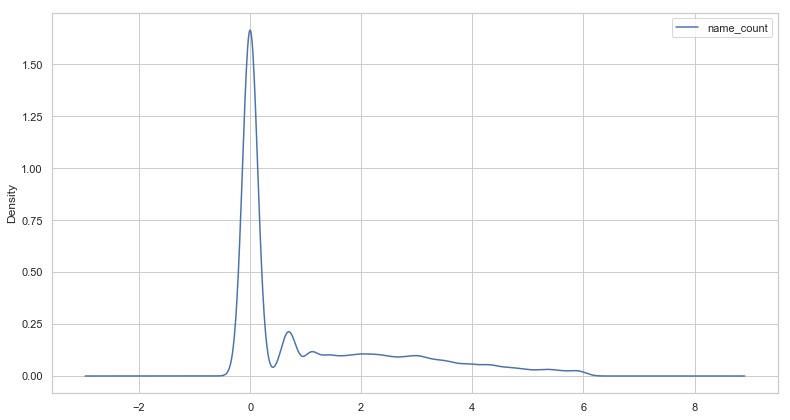

In [13]:
# name
# hit等频分组

name_col = dt.name.value_counts().reset_index(inplace=False)
name_col.columns = ['name', 'name_count']
dt = dt.merge(name_col, how='left', on=['name'])

np.log(dt[['name_count']]).plot.density()

name_count_qcut = pd.qcut(list(set(list(dt['name_count']))), 7) 
name_count_qcut


dt.loc[dt.name_count<=19.143, ['name_count']] = 0
dt.loc[(19.143<dt.name_count) & (dt.name_count<=37.286), ['name_count']] = 1
dt.loc[(37.286<dt.name_count) & (dt.name_count<=55.429), ['name_count']] = 2
dt.loc[(55.429<dt.name_count) & (dt.name_count<=75.571), ['name_count']] = 3 
dt.loc[(75.571<dt.name_count) & (dt.name_count<=103.714), ['name_count']] = 4
dt.loc[(103.714<dt.name_count) & (dt.name_count<=169.0), ['name_count']] = 5 
dt.loc[169.0<dt.name_count, ['name_count']] = 6

# 删除name列
dt.drop(['name'], axis=1, inplace=True)


# name_count价格

name_count_price = dt.loc[dt.isTrain==1, ['name_count','price']].groupby('name_count').agg(['mean', 'max', 'min', 'std']).reset_index()
name_count_price.columns = ['name_count', 'name_count_price_mean', 'name_count_price_max', 
                            'name_count_price_min', 'name_count_price_std']
dt = dt.merge(name_count_price, how='left', on=['name_count'])


## 缺失值

In [14]:
dt.bodyType.fillna(value=-1, inplace=True)
dt.fuelType.fillna(value=-1, inplace=True)
dt.gearbox.fillna(value=-1, inplace=True)
dt.model.fillna(value=stats.mode(dt.model)[0][0], inplace=True)


## 类别合并

In [15]:
# bodyType类别合并
dt.loc[(dt.bodyType==0) | (dt.bodyType==2), ['bodyType']] = 0
dt.loc[(dt.bodyType==4) | (dt.bodyType==5), ['bodyType']] = 4


# fuelType类别合并
# 合并之后与价格相关性不大
dt.loc[(dt.fuelType==0) | (dt.fuelType==2) | (dt.fuelType==5), ['fuelType']] = 0

## bodyType

- 值少

In [16]:
# bodyType
# 计算hit

bodyType_count = dt.bodyType.value_counts().reset_index(inplace=False)
bodyType_count.columns = ['bodyType', 'bodyType_count']
dt = dt.merge(bodyType_count, how='left', on=['bodyType'])

# 计算价格

bodyType_price = dt.loc[dt.isTrain==1, ['bodyType','price']].groupby('bodyType').agg(['mean', 'max', 'min', 'std']).reset_index()
bodyType_price.columns = ['bodyType', 'bodyType_price_mean', 'bodyType_price_max', 
                            'bodyType_price_min', 'bodyType_price_std']
dt = dt.merge(bodyType_price, how='left', on=['bodyType'])

## fuelType

- 值少

In [17]:
# fuelType
# 计算hit

fuelType_count = dt.fuelType.value_counts().reset_index(inplace=False)
fuelType_count.columns = ['fuelType', 'fuelType_count']
dt = dt.merge(fuelType_count, how='left', on=['fuelType'])

# 计算价格

fuelType_price = dt.loc[dt.isTrain==1, ['fuelType','price']].groupby('fuelType').agg(['mean', 'max', 'min', 'std']).reset_index()
fuelType_price.columns = ['fuelType', 'fuelType_price_mean', 'fuelType_price_max', 
                            'fuelType_price_min', 'fuelType_price_std']
dt = dt.merge(fuelType_price, how='left', on=['fuelType'])

## gearbox

- 值少

In [18]:
# gearbox
# 计算hit

gearbox_count = dt.gearbox.value_counts().reset_index(inplace=False)
gearbox_count.columns = ['gearbox', 'gearbox_count']
dt = dt.merge(gearbox_count, how='left', on=['gearbox'])

# 计算价格

gearbox_price = dt.loc[dt.isTrain==1, ['gearbox','price']].groupby('gearbox').agg(['mean', 'max', 'min', 'std']).reset_index()
gearbox_price.columns = ['gearbox', 'gearbox_price_mean', 'gearbox_price_max', 
                            'gearbox_price_min', 'gearbox_price_std']
dt = dt.merge(gearbox_price, how='left', on=['gearbox'])

## regionCode

[(0.999, 31.8], (0.999, 31.8], (124.2, 515.0], (0.999, 31.8], (0.999, 31.8], ..., (124.2, 515.0], (124.2, 515.0], (124.2, 515.0], (124.2, 515.0], (124.2, 515.0]]
Length: 155
Categories (5, interval[float64]): [(0.999, 31.8] < (31.8, 62.6] < (62.6, 93.4] < (93.4, 124.2] < (124.2, 515.0]]

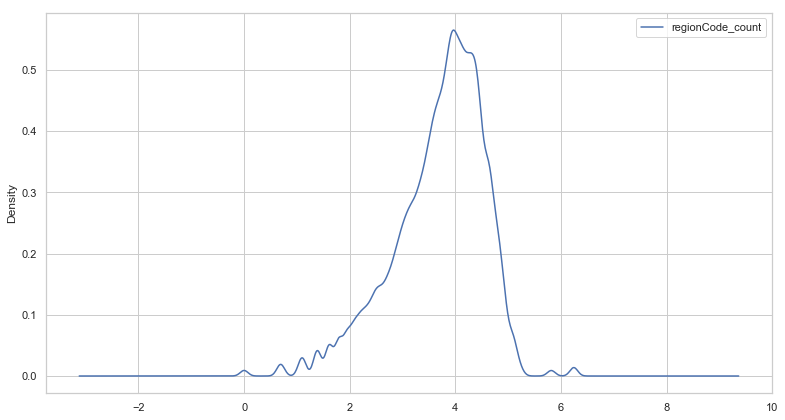

In [19]:
# regionCode
# hit等频分组

regionCode_col = dt.regionCode.value_counts().reset_index(inplace=False)
regionCode_col.columns = ['regionCode', 'regionCode_count']
dt = dt.merge(regionCode_col, how='left', on=['regionCode'])

np.log(dt[['regionCode_count']]).plot.density()

regionCode_count_qcut = pd.qcut(list(set(list(dt['regionCode_count']))), 5) 
regionCode_count_qcut

dt.loc[dt.regionCode_count<=31.8, ['regionCode_count']] = 0
dt.loc[(31.8<dt.regionCode_count) & (dt.regionCode_count<=62.6), ['regionCode_count']] = 1
dt.loc[(62.6<dt.regionCode_count) & (dt.regionCode_count<=93.4), ['regionCode_count']] = 2
dt.loc[(93.4<dt.regionCode_count) & (dt.regionCode_count<=124.2), ['regionCode_count']] = 3
dt.loc[124.2<dt.regionCode_count, ['regionCode_count']] = 4

# 删除regionCode列
dt.drop(['regionCode'], axis=1, inplace=True)

# regionCode_count价格

regionCode_count_price = dt.loc[dt.isTrain==1, ['regionCode_count','price']].groupby('regionCode_count').agg(['mean', 'max', 'min', 'std']).reset_index()
regionCode_count_price.columns = ['regionCode_count', 'regionCode_count_price_mean', 'regionCode_count_price_max', 
                            'regionCode_count_price_min', 'regionCode_count_price_std']
dt = dt.merge(regionCode_count_price, how='left', on=['regionCode_count'])

## 车龄

In [20]:
set(dt[dt.isTrain==0].car_age) - set(dt[dt.isTrain==1].car_age)

{0}

In [21]:
dt.loc[dt.car_age==0, 'car_age'] = 1

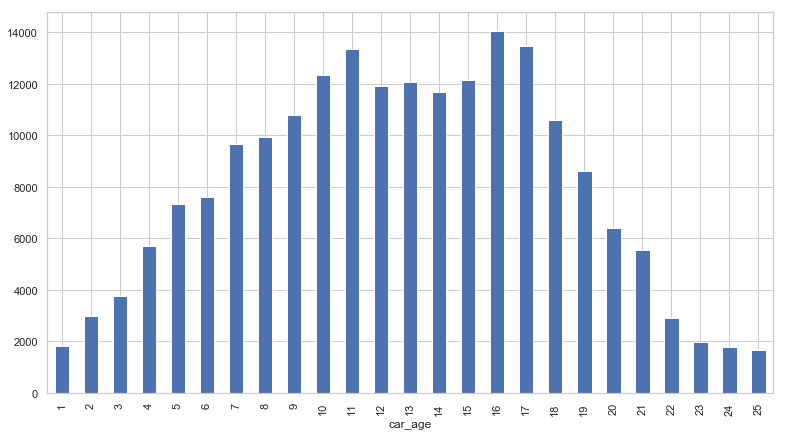

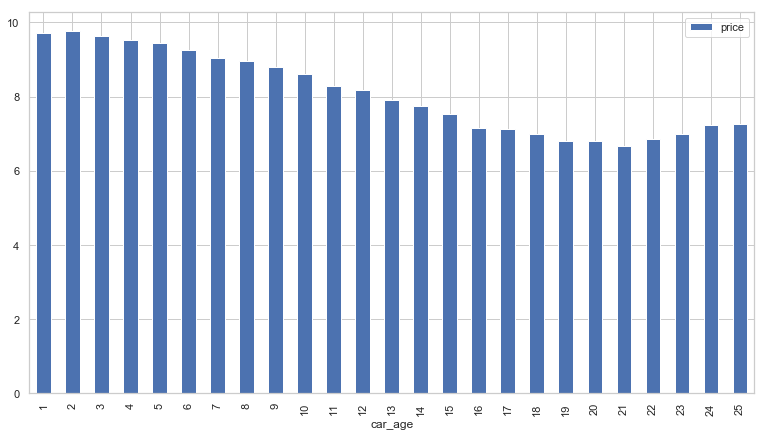

In [22]:
dt[['car_age']].groupby('car_age').size().plot.bar()
dt.loc[dt.isTrain==1, ['car_age','price']].groupby('car_age').mean().plot.bar()

## car_age对价格影响大，增加对应车龄的平均价格

In [23]:
car_age_avg_price = dt.loc[dt.isTrain==1, ['car_age','price']].groupby('car_age').mean().reset_index()
car_age_avg_price.columns = ['car_age', 'car_age_avg_price']
dt = dt.merge(car_age_avg_price, how='left', on=['car_age'])


## 类别hit与price分桶

- 对未发生目标泄露的特征还是按照老的方式分桶处理。
- 同时将这些原始特征也做保留，不删除。

### model

[(0.999, 70.714], (0.999, 70.714], (349.857, 559.857], (0.999, 70.714], (0.999, 70.714], ..., (349.857, 559.857], (349.857, 559.857], (349.857, 559.857], (559.857, 1606.143], (1606.143, 15659.0]]
Length: 207
Categories (7, interval[float64]): [(0.999, 70.714] < (70.714, 139.571] < (139.571, 216.571] < (216.571, 349.857] < (349.857, 559.857] < (559.857, 1606.143] < (1606.143, 15659.0]]

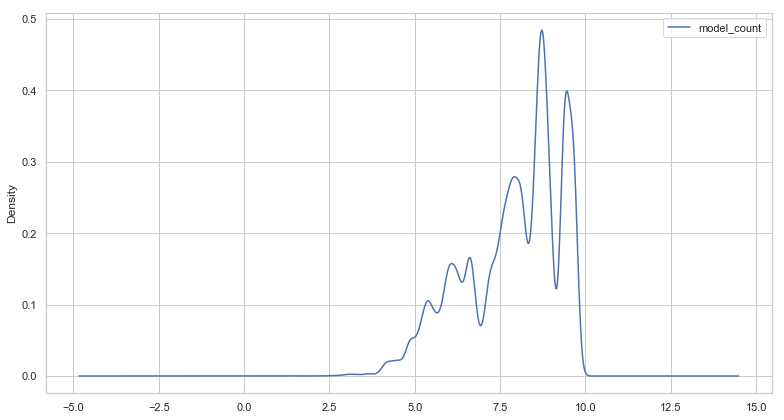

In [24]:
# model
# hit等频分组

model_col = dt.model.value_counts().reset_index(inplace=False)
model_col.columns = ['model', 'model_count']
dt = dt.merge(model_col, how='left', on=['model'])

np.log(dt[['model_count']]).plot.density()

model_count_qcut = pd.qcut(list(set(list(dt['model_count']))), 7) 
model_count_qcut

dt.loc[dt.model_count<=70.714, ['model_count']] = 0
dt.loc[(70.714<dt.model_count) & (dt.model_count<=139.571), ['model_count']] = 1
dt.loc[(139.571<dt.model_count) & (dt.model_count<=216.571), ['model_count']] = 2
dt.loc[(216.571<dt.model_count) & (dt.model_count<=349.857), ['model_count']] = 3 
dt.loc[(349.857<dt.model_count) & (dt.model_count<=559.857), ['model_count']] = 4
dt.loc[(559.857<dt.model_count) & (dt.model_count<=1606.143), ['model_count']] = 5 
dt.loc[1606.143<dt.model_count, ['model_count']] = 6

0         (6.635, 7.312]
1         (7.988, 8.664]
2          (8.664, 9.34]
3          (8.664, 9.34]
4         (6.635, 7.312]
               ...      
199995    (7.988, 8.664]
199996    (7.312, 7.988]
199997    (7.988, 8.664]
199998     (8.664, 9.34]
199999    (7.312, 7.988]
Name: model_price, Length: 200000, dtype: category
Categories (7, interval[float64]): [(5.954, 6.635] < (6.635, 7.312] < (7.312, 7.988] < (7.988, 8.664] < (8.664, 9.34] < (9.34, 10.017] < (10.017, 10.693]]

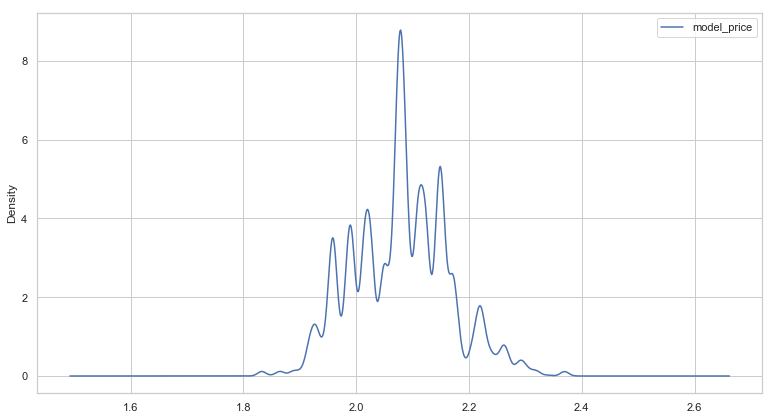

In [25]:
# model
# 价格等距分组


model_price = dt.loc[dt.isTrain==1, ['model','price']].groupby('model').mean().reset_index()
model_price.columns = ['model', 'model_price']
dt = dt.merge(model_price, how='left', on=['model'])

np.log(dt[['model_price']]).plot.density()

model_cut = pd.cut(dt.model_price, 7) 
model_cut


dt['model_price_backet'] = dt['model_price']
dt.loc[dt.model_price_backet<=6.635, ['model_price_backet']] = 0
dt.loc[(6.635<dt.model_price_backet) & (dt.model_price_backet<=7.312), ['model_price_backet']] = 1
dt.loc[(7.312<dt.model_price_backet) & (dt.model_price_backet<=7.988), ['model_price_backet']] = 2
dt.loc[(7.988<dt.model_price_backet) & (dt.model_price_backet<=8.664), ['model_price_backet']] = 3
dt.loc[(8.664<dt.model_price_backet) & (dt.model_price_backet<=9.34), ['model_price_backet']] = 4
dt.loc[(9.34<dt.model_price_backet) & (dt.model_price_backet<=10.017), ['model_price_backet']] = 5
dt.loc[10.017<dt.model_price_backet, ['model_price_backet']] = 6


# dt.drop(['model'], axis=1, inplace=True)

### brand

[(3167.143, 12009.0], (298.857, 747.571], (10.999, 298.857], (2056.143, 3167.143], (747.571, 1320.143], ..., (10.999, 298.857], (747.571, 1320.143], (747.571, 1320.143], (747.571, 1320.143], (10.999, 298.857]]
Length: 39
Categories (7, interval[float64]): [(10.999, 298.857] < (298.857, 747.571] < (747.571, 1320.143] < (1320.143, 2056.143] < (2056.143, 3167.143] < (3167.143, 12009.0] < (12009.0, 41828.0]]

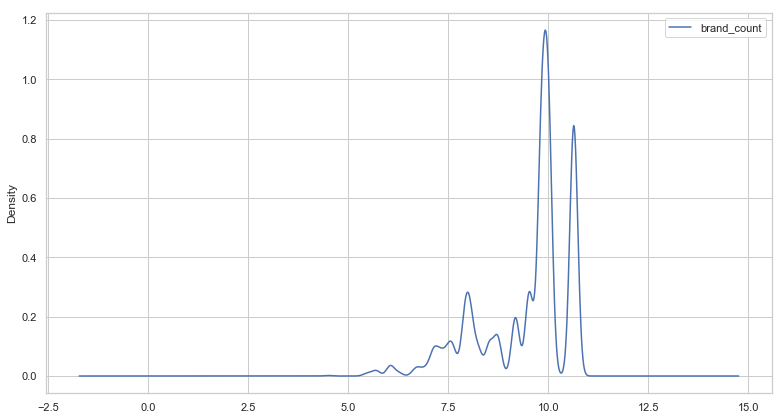

In [26]:
# brand
# hit等频分组

brand_col = dt.brand.value_counts().reset_index(inplace=False)
brand_col.columns = ['brand', 'brand_count']
dt = dt.merge(brand_col, how='left', on=['brand'])

np.log(dt[['brand_count']]).plot.density()

brand_count_qcut = pd.qcut(list(set(list(dt['brand_count']))), 7) 
brand_count_qcut

dt.loc[dt.brand_count<=298.857, ['brand_count']] = 0
dt.loc[(298.857<dt.brand_count) & (dt.brand_count<=747.571), ['brand_count']] = 1
dt.loc[(747.571<dt.brand_count) & (dt.brand_count<=1320.143), ['brand_count']] = 2
dt.loc[(1320.143<dt.brand_count) & (dt.brand_count<=2056.143), ['brand_count']] = 3 
dt.loc[(2056.143<dt.brand_count) & (dt.brand_count<=3167.143), ['brand_count']] = 4
dt.loc[(3167.143<dt.brand_count) & (dt.brand_count<=12009.0), ['brand_count']] = 5 
dt.loc[12009.0<dt.brand_count, ['brand_count']] = 6

0         (7.248, 7.745]
1         (8.242, 8.739]
2         (8.739, 9.236]
3         (8.242, 8.739]
4         (7.248, 7.745]
               ...      
199995    (8.242, 8.739]
199996    (7.745, 8.242]
199997    (8.242, 8.739]
199998    (8.242, 8.739]
199999    (7.248, 7.745]
Name: brand_price, Length: 200000, dtype: category
Categories (7, interval[float64]): [(6.747, 7.248] < (7.248, 7.745] < (7.745, 8.242] < (8.242, 8.739] < (8.739, 9.236] < (9.236, 9.733] < (9.733, 10.231]]

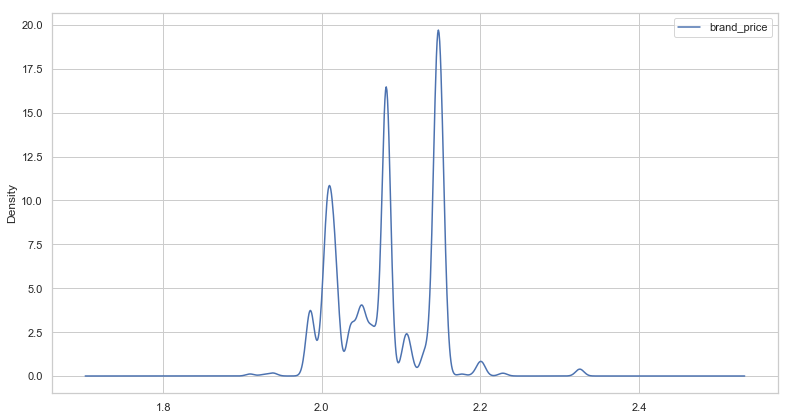

In [27]:
# brand
# 价格等距分组


brand_price = dt.loc[dt.isTrain==1, ['brand','price']].groupby('brand').mean().reset_index()
brand_price.columns = ['brand', 'brand_price']
dt = dt.merge(brand_price, how='left', on=['brand'])

np.log(dt[['brand_price']]).plot.density()

brand_cut = pd.cut(dt.brand_price, 7) 
brand_cut

dt['brand_price_backet'] = dt['brand_price']
dt.loc[dt.brand_price_backet<=7.248, ['brand_price_backet']] = 0
dt.loc[(7.248<dt.brand_price_backet) & (dt.brand_price_backet<=7.745), ['brand_price_backet']] = 1
dt.loc[(7.745<dt.brand_price_backet) & (dt.brand_price_backet<=8.242), ['brand_price_backet']] = 2
dt.loc[(8.242<dt.brand_price_backet) & (dt.brand_price_backet<=8.739), ['brand_price_backet']] = 3
dt.loc[(8.739<dt.brand_price_backet) & (dt.brand_price_backet<=9.236), ['brand_price_backet']] = 4
dt.loc[(9.236<dt.brand_price_backet) & (dt.brand_price_backet<=9.733), ['brand_price_backet']] = 5
dt.loc[9.733<dt.brand_price_backet, ['brand_price_backet']] = 6



# dt.drop(['brand'], axis=1, inplace=True)


## top30指标

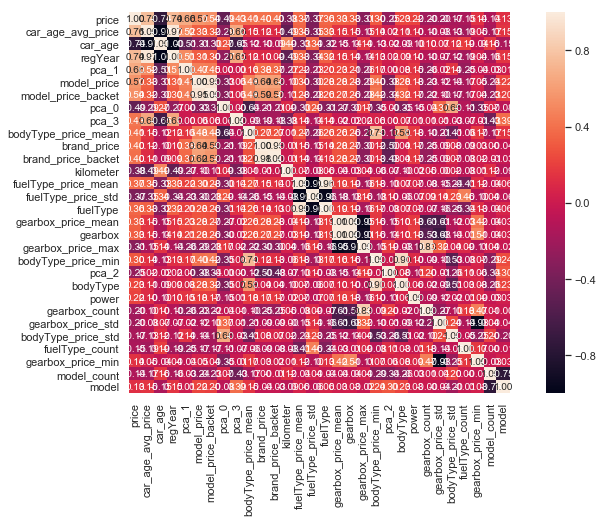

In [28]:
corr_plot(topk=30, dt=dt)

# 删除列

- 取值单一或者已经用此提取过其他特征

In [29]:
dt.drop(['creatDate', 'regYear', 'creatYear', 'seller', 'offerType'], axis=1, inplace=True)

# 对数处理

In [30]:
dt.loc[:,['kilometer']] = dt[['kilometer']].apply(lambda x: np.log(x + 1))
dt.loc[:,['power']] = dt[['power']].apply(lambda x: np.log(x + 1))

In [31]:
dt.columns

Index(['SaleID', 'bodyType', 'brand', 'fuelType', 'gearbox', 'isTrain',
       'kilometer', 'model', 'notRepairedDamage', 'power', 'price',
       'salesDays', 'car_age', 'day_of_week', 'holiday', 'creatWeek_sin',
       'creatWeek_cos', 'creatMonth_sin', 'creatMonth_cos',
       'creatYearMonth_hit', 'creatYearMonth_hit_diff1',
       'creatYearMonth_hit_huanbi', 'creatYearMonth_price',
       'creatYearMonth_price_diff1', 'creatYearMonth_price_huanbi',
       'creatDate_is_Weekend', 'creatDateStr_hit', 'creatDateStr_hit_diff1',
       'creatDateStr_hit_huanbi', 'creatDateStr_price',
       'creatDateStr_price_diff1', 'creatDateStr_price_huanbi', 'day',
       'days_to_side', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4',
       'name_count', 'name_count_price_mean', 'name_count_price_max',
       'name_count_price_min', 'name_count_price_std', 'bodyType_count',
       'bodyType_price_mean', 'bodyType_price_max', 'bodyType_price_min',
       'bodyType_price_std', 'fuelType_count', 'fuel

# 数据加载

In [32]:
def load_data(dt=dt, m_type = 'xgb-model'):
    """
        加载数据，输出放入模型的特征features列表以及特征列表中是类别型的列表cate_feat
        对cate_feat进行了LabelEncoder，针对LGB增加category转化
    """
    # 参考资料：树模型LabelEncoder——https://www.cnblogs.com/ranjiewen/p/9105954.html:

    noise_feature = [myid, goal, 'isTrain']
    category_feature = ['bodyType', 'brand', 'fuelType', 'gearbox', 'model', 'notRepairedDamage', 
                        'day_of_week', 'holiday','creatDate_is_Weekend']
    numeric_feature = [i for i in dt.columns if i not in category_feature + noise_feature]
    
    lbl = LabelEncoder()  
    for col in category_feature:
        dt[col] = lbl.fit_transform(dt[col].astype(str))
    if m_type == 'lgb-model':
        for catf in category_feature:
            dt[catf] = dt[catf].astype('category')         
    features = numeric_feature + category_feature
    train = dt[dt.isTrain==1]
    test = dt[dt.isTrain==0]


    return (train, test, features, category_feature)

# catboost训练与分析

In [70]:
print("=> 载入数据中...")
# train, test, features, category_feature = load_data(dt=dt, m_type='lgb-model')
print("Train的info...", train.info())
mean_val = test['car_age_avg_price'].mean()
test['car_age_avg_price'].fillna(mean_val, inplace=True)
# 忽略特征
ignore_col = ['creatWeek_sin', 'creatDateStr_hit', 'creatDate_is_Weekend', 'creatDateStr_price_diff1', 
              'creatYearMonth_price_diff1', 'creatDateStr_price_huanbi', 'creatDateStr_hit_huanbi', 
              'creatYearMonth_price_huanbi', 'creatYearMonth_price', 'creatYearMonth_hit', 'gearbox',
              'creatMonth_sin', 'creatMonth_cos', 'creatDateStr_hit_diff1', 'creatYearMonth_hit_diff1', 
              'creatYearMonth_hit_huanbi', 'regionCode_count_price_std', 'regionCode_count_price_min',
              'day', 'holiday', 'fuelType_price_max', 'regionCode_count_price_max', 'creatWeek_cos', 
              'fuelType_count'] 

features =  [i for i in features if i not in ignore_col]

category_feature = [i for i in category_feature if i not in ignore_col]


print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)


print("Train CatBoost Decision Tree...")
cat_model = CatBoostRegressor(iterations=30000,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='MAE',
                             loss_function = 'MAE',
                             colsample_bylevel = 0.85, 
                             metric_period = 500,
                             early_stopping_rounds = 50,
                             bagging_temperature=0.2,
                             od_type='Iter',
#                              od_wait=20,
                             random_seed = 2020002)

cat_model.fit(train[features], train[goal],
             eval_set=(train[features], train[goal]),
             cat_features=category_feature,
             use_best_model=True,
             verbose=True,
             plot=True)

=> 载入数据中...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Data columns (total 71 columns):
SaleID                         150000 non-null int64
bodyType                       150000 non-null category
brand                          150000 non-null category
fuelType                       150000 non-null category
gearbox                        150000 non-null category
isTrain                        150000 non-null int64
kilometer                      150000 non-null float64
model                          150000 non-null category
notRepairedDamage              150000 non-null category
power                          150000 non-null float64
price                          150000 non-null float64
salesDays                      150000 non-null int64
car_age                        150000 non-null int64
day_of_week                    150000 non-null category
holiday                        150000 non-null category
creatWeek_sin                  150000 non-null float

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.7925467	test: 7.7925467	best: 7.7925467 (0)	total: 274ms	remaining: 1h 22m 12s
500:	learn: 0.1492390	test: 0.1492013	best: 0.1492013 (500)	total: 2m 1s	remaining: 1h 10m 52s
1000:	learn: 0.1301492	test: 0.1301154	best: 0.1301154 (1000)	total: 4m 5s	remaining: 1h 9m 33s
1500:	learn: 0.1220155	test: 0.1220124	best: 0.1220124 (1500)	total: 6m 9s	remaining: 1h 7m 43s
2000:	learn: 0.1167037	test: 0.1167521	best: 0.1167521 (2000)	total: 8m 13s	remaining: 1h 5m 44s
2500:	learn: 0.1128835	test: 0.1129944	best: 0.1129944 (2500)	total: 10m 18s	remaining: 1h 3m 50s
3000:	learn: 0.1098456	test: 0.1100472	best: 0.1100472 (3000)	total: 12m 22s	remaining: 1h 1m 53s
3500:	learn: 0.1073514	test: 0.1076360	best: 0.1076360 (3500)	total: 14m 29s	remaining: 59m 59s
4000:	learn: 0.1051868	test: 0.1055796	best: 0.1055796 (4000)	total: 16m 41s	remaining: 58m 22s
4500:	learn: 0.1032227	test: 0.1037181	best: 0.1037181 (4500)	total: 18m 47s	remaining: 56m 20s
5000:	learn: 0.1017128	test: 0.1023208	be

## 特征重要性

In [35]:
# # Feature Importance 可视化
def func_plot_importance(df_imp):
    df_imp.plot(kind='barh', x='Features', y='Importance', figsize=(20, 10), color="g", alpha=0.5)

def display_importance(cb_model, columns, plotting=True):
    importances = cb_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    importance_list = []
    for f in range(len(columns)):
        importance_list.append((columns[indices[f]], importances[indices[f]]))
        print("%2d) %-*s %f" % (f + 1, 30, columns[indices[f]],
                                importances[indices[f]]))
    if plotting:
        df_imp = pd.DataFrame(
            importance_list, columns=['Features', 'Importance'])
        df_imp = df_imp.sort_values(by='Importance', ascending=True)
        func_plot_importance(df_imp)
    return df_imp

 1) pca_1                          17.880453
 2) pca_0                          15.068881
 3) pca_3                          10.199388
 4) car_age_avg_price              9.757153
 5) car_age                        6.923927
 6) pca_2                          3.801306
 7) notRepairedDamage              3.116944
 8) power                          3.020336
 9) brand_price                    2.779088
10) model_price                    2.521499
11) kilometer                      1.906464
12) bodyType_price_min             1.670686
13) bodyType                       1.649679
14) fuelType                       1.632862
15) pca_4                          1.497534
16) fuelType_price_mean            1.445466
17) model_price_backet             1.291199
18) gearbox_count                  1.230446
19) bodyType_price_mean            1.204248
20) brand_price_backet             1.058443
21) fuelType_price_std             0.980241
22) gearbox_price_max              0.969808
23) model_count              

,Features,Importance
51,regionCode_count_price_max,0.005266
50,fuelType_price_max,0.007820
49,holiday,0.036734
48,day,0.044006
47,regionCode_count_price_min,0.046283
46,regionCode_count_price_std,0.048572
45,name_count_price_mean,0.051241
44,fuelType_count,0.064828
43,creatWeek_cos,0.065518
42,days_to_side,0.085706


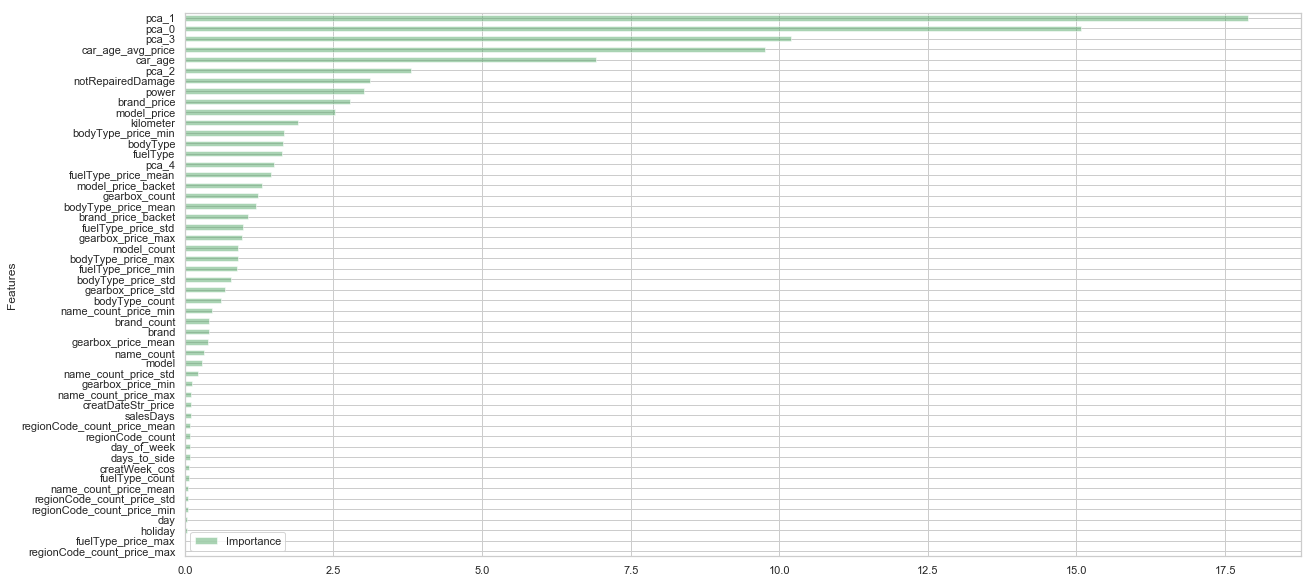

In [71]:
# # Feature Importance
display_importance(cb_model=cat_model, columns=dt[features].columns) 

## 预测与保存结果

In [72]:
cat_price_pre = np.exp(cat_model.predict(test[features]))-1

In [73]:
cat_price_pre

array([34563.55201542,   328.08199544,  5902.29878248, ...,
        7935.719261  ,  8814.97374978,  3262.80931769])

In [ ]:
submission = pd.DataFrame({myid: test[myid], goal: np.int64(cat_price_pre)})
submission.to_csv("./result/sample_submit_catboost.csv", index=False)